In [1]:
import sys
import os
# Detect if running in Google Colab
if "google.colab" in sys.modules:
    !pip install ultralytics

    # make utils dir
    os.makedirs("/content/src/utils", exist_ok=True)
    !wget -O /content/src/utils/utils.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/utils/utils.py
    !wget -O /content/src/utils/preprocess_utils.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/utils/preprocess_utils.py
    sys.path.append("/content/src")

    # make scripts dir
    os.makedirs("/content/src/scripts", exist_ok=True)
    !wget -O /content/src/scripts/inference.py https://raw.githubusercontent.com/jayyang17/pool_management_system/main/src/scripts/inference.py

    # import config from git
    !wget -O /content/config.yaml https://raw.githubusercontent.com/jayyang17/pool_management_system/main/config.yaml

    # get training data from s3
    os.makedirs("/content/artifact", exist_ok=True)
    !wget aws s3 cp 'https://poolmanagementsystem.s3.ap-southeast-1.amazonaws.com/raw_data/data.zip' -O /content/artifact/data.zip


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.2/922.2 kB 32.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [2]:
# Normal import (works in both local & Colab)
import ultralytics
from src.utils.utils import unzip_file, read_yaml, write_yaml, save_model, zip_model
from src.utils.preprocess_utils import process_dataset, augment_images, balance_dataset,create_yolo_data_yaml, split_train_val


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Import Configurations

In [3]:
# config
config = read_yaml('./config.yaml')

In [4]:
import yaml

# Label studio data
RAW_DATA_PATH = config["RAW_DATA_PATH"]

# PATH CONFIGURATIONS
ARTIFACT_DIR      = config["ARTIFACT_DIR"]
ORIGINAL_PATH     = config["ORIGINAL_PATH"]

# Original data paths (from Label Studio)
ORIGINAL_IMG_DIR  = config["ORIGINAL_IMG_DIR"]    # Images from Label Studio
YOLO_LABELS_DIR   = config["YOLO_LABELS_DIR"]     # YOLO labels from Label Studio

# Resized data paths (before augmentation)
RESIZED_IMG_DIR   = config["RESIZED_IMG_DIR"]     # Resized images
RESIZED_LABELS_DIR = config["RESIZED_LABELS_DIR"]    # Updated YOLO labels

# Augmented data paths
AUGMENTED_IMG_DIR   = config["AUGMENTED_IMG_DIR"]     # Augmented images
AUGMENTED_LABELS_DIR = config["AUGMENTED_LABELS_DIR"]   # Augmented YOLO labels

# Target training directories
TRAINING_IMG_DIR   = config["TRAINING_IMG_DIR"]
TRAINING_LABELS_DIR = config["TRAINING_LABELS_DIR"]

# Other paths
SOURCE_TRAIN_DIR  = config["SOURCE_TRAIN_DIR"]
MODEL_OUTPUT_DIR  = config["MODEL_OUTPUT_DIR"]
ZIP_MODEL_PATH    = config["ZIP_MODEL_PATH"]
CLASSES_TXT_PATH  = config["CLASSES_TXT_PATH"]
DATA_YAML_PATH    = config["MODEL"]["DATA_YAML_PATH"]

# data path for model training
# Determine the base path dynamically, to avoid changing the env
if os.path.exists('/content'):
    # Set the dataset path for Colab
    DATA_PATH = '/content/data'
else:
    # For local
    DATA_PATH = os.path.join(os.getcwd(), 'data')




# Upload Dataset and prepare training data

In [5]:
# unzip the zip file generated from label-studio into the output dir
unzip_file(RAW_DATA_PATH,ORIGINAL_PATH)

Successfully extracted ./artifact/data.zip to ./artifact/original_data


# Preprocess

In [6]:
# resize the image
process_dataset(ORIGINAL_IMG_DIR, RESIZED_IMG_DIR, RESIZED_LABELS_DIR, YOLO_LABELS_DIR)

Processed pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg
Processed train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg
Processed fd6099d9-Gemini_Generated_Image_y1j2emy1j2emy1j2.jpg
Processed train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg
Processed pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg
Processed train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg
Processed train-07_png.rf.588b8660db71799422e9f255221198f9.jpg
Processed pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg
Processed train-03_png.rf.da782c83805ae11291f695ff003daebe.jpg
Processed pinterest-04_jpg.rf.3e7d9f90986b4dccb7cabed2f1023bf1.jpg
Processed pinterest-12_jpg.rf.e7c79282f4403830711b1a09433dcf46.jpg
Processed pinterest-15_jpg.rf.5105a1f644e876833001fa4a6edb5c5a.jpg
Processed pinterest-07_jpg.rf.df6d713578885ff1eb07fbca5929e692.jpg
Processed pinterest-11_jpg.rf.98389ab55b22740e1bd60b98a7311ad4.jpg
Processed pinterest-14_jpg.rf.19dc64f82b4406ee0f2e31b4cccde8df.jpg
Processed train-06_

In [7]:
augment_images(RESIZED_IMG_DIR, RESIZED_LABELS_DIR, AUGMENTED_IMG_DIR, AUGMENTED_LABELS_DIR)

Augmented: pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg --> aug_pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg
Augmented: train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg --> aug_train-04_png.rf.ca3b439540bf9020a5c9525eb8d9c7ca.jpg
Augmented: fd6099d9-Gemini_Generated_Image_y1j2emy1j2emy1j2.jpg --> aug_fd6099d9-Gemini_Generated_Image_y1j2emy1j2emy1j2.jpg
Augmented: train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg --> aug_train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg
Augmented: pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg --> aug_pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg
Augmented: train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg --> aug_train-05_png.rf.9139c24a5208120e3278d4e7aaf9b1b8.jpg
Augmented: train-07_png.rf.588b8660db71799422e9f255221198f9.jpg --> aug_train-07_png.rf.588b8660db71799422e9f255221198f9.jpg
Augmented: pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg --> aug_pinterest-01_jpg.rf.ad8480119674c

In [8]:
# Data splitting ratios
DATA_SPLIT = config["DATA_SPLIT"]
IMG_BALANCE_RATIO = DATA_SPLIT["img_balance_ratio"]

balance_dataset(
    RESIZED_IMG_DIR,
    RESIZED_LABELS_DIR,
    AUGMENTED_IMG_DIR,
    AUGMENTED_LABELS_DIR,
    TRAINING_IMG_DIR,
    TRAINING_LABELS_DIR,
    ratio_original=IMG_BALANCE_RATIO,
    total_samples=None)


Balanced dataset created with 37 original and 37 augmented images.


## split training and validation

In [9]:
# split training and validation images
TRAIN_RATIO       = DATA_SPLIT["train_ratio"]
split_train_val(TRAINING_IMG_DIR, TRAINING_LABELS_DIR, TRAIN_RATIO)

Found 74 images and 74 labels.
Splitting data: 59 for training, 15 for validation.
Data split complete! Check the 'train/' and 'validation/' folders.


In [10]:
# create the data.yaml file
create_yolo_data_yaml(DATA_PATH, CLASSES_TXT_PATH, DATA_YAML_PATH)

# check the data.yaml file
read_yaml(DATA_YAML_PATH)

YAML file created at ./data.yaml


{'path': '/content/data',
 'train': 'train/images',
 'val': 'validation/images',
 'nc': 2,
 'names': ['occupied', 'empty']}

# Model Training

In [11]:
from ultralytics import YOLO

# Define training parameters
PRETRAIN_MODEL = "yolov8m.pt"       # Pretrained model
DATA_YAML_PATH = "data.yaml"        # Path to data config
IMG_SIZE = 640                      # Standard YOLO input size
EPOCHS = 100                         # Reduce to prevent overfitting
BATCH_SIZE = 16                     # Increase if GPU allows
LR0 = 0.0005                        # Lower LR for more stable training
WEIGHT_DECAY = 0.0001               # Reduce overfitting risk
PATIENCE = 20                       # Keep early stopping but lower patience

# Load YOLO model
model = YOLO(PRETRAIN_MODEL)

# Start training with optimized settings
results = model.train(
    data=DATA_YAML_PATH,
    epochs=EPOCHS,
    imgsz=IMG_SIZE,
    batch=BATCH_SIZE,
    lr0=LR0,
    weight_decay=WEIGHT_DECAY,
    patience=PATIENCE
)

print("Training complete!")


100%|██████████| 49.7M/49.7M [00:01<00:00, 45.8MB/s]


Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=data.yaml, epochs=100, time=None, patience=20, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width

100%|██████████| 755k/755k [00:00<00:00, 108MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 235MB/s]


AMP: checks passed ✅


train: Scanning /content/data/train/labels... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1929.98it/s]

train: New cache created: /content/data/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/data/validation/labels... 15 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15/15 [00:00<00:00, 943.18it/s]

val: New cache created: /content/data/validation/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0001), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.13G      2.616      3.709      1.987        315        640: 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:01<00:00,  1.91s/it]

                   all         15        231     0.0643     0.0805     0.0334     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.18G      2.479      3.226      1.904        248        640: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         15        231      0.272      0.232      0.177     0.0699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.34G      2.153      2.197      1.582        139        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         15        231      0.373      0.328      0.307      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.36G      2.056      2.001       1.54        273        640: 100%|██████████| 4/4 [00:02<00:00,  1.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]

                   all         15        231      0.246      0.346      0.211     0.0963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.35G      2.016      1.879      1.543        255        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         15        231      0.233      0.284      0.247      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.16G      1.906      1.767      1.473        235        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         15        231     0.0956      0.486      0.108     0.0544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.36G      1.827      1.639      1.397        212        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         15        231      0.291      0.428      0.289      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.23G       1.91      1.646      1.474        274        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         15        231      0.255      0.443       0.34       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.27G      1.826      1.526       1.46        292        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         15        231      0.265      0.395      0.286      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100       6.4G      1.817      1.565      1.471        236        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.13it/s]

                   all         15        231      0.327      0.371      0.358      0.177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       6.4G      1.851      1.496      1.469        232        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         15        231      0.272       0.45       0.28      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.46G      1.895      1.546      1.472        252        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        231      0.486      0.565      0.501      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.18G      1.867      1.484      1.506        179        640: 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         15        231      0.574      0.513      0.533      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.17G       1.79      1.439       1.46        274        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.45it/s]

                   all         15        231      0.503       0.46      0.476      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.46G      1.704      1.432      1.428        220        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        231      0.343      0.466      0.405      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.36G      1.758      1.398      1.416        286        640: 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         15        231      0.592      0.406      0.479      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.44G      1.734      1.401      1.437        163        640: 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         15        231       0.62       0.44      0.508      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.37G      1.727      1.397      1.409        153        640: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         15        231      0.322      0.333      0.372      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.35G      1.735      1.374      1.395        301        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         15        231      0.495      0.492      0.458      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.23G      1.663      1.313      1.398        218        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.56it/s]

                   all         15        231        0.6      0.454      0.502      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.22G      1.761      1.385      1.393        186        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         15        231      0.333       0.41      0.295      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.34G      1.569      1.258      1.361        223        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         15        231      0.585      0.419      0.417      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.34G      1.614      1.258      1.313        322        640: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         15        231      0.547      0.547      0.504      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.26G       1.56      1.272      1.365        210        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.33it/s]

                   all         15        231       0.55      0.537      0.509      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.37G      1.671      1.319      1.413        211        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.67it/s]

                   all         15        231      0.459      0.488      0.453      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.21G      1.792      1.347      1.373        176        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        231      0.509       0.47      0.472      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100       6.4G      1.721      1.317      1.338        231        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         15        231      0.569      0.463      0.505      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.32G      1.633      1.282      1.389        224        640: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.71it/s]

                   all         15        231      0.578      0.476      0.488      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.31G      1.701       1.29      1.376        251        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        231      0.512      0.522      0.507      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.37G      1.645       1.14      1.333        220        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         15        231      0.595      0.465      0.529      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.32G      1.473      1.094      1.267        195        640: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]

                   all         15        231      0.662      0.457      0.548      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.36G      1.558      1.103      1.329        232        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        231      0.564      0.465      0.518      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100       6.3G      1.596      1.157      1.332        260        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         15        231      0.579      0.533      0.598      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.25G      1.595       1.27      1.409        237        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         15        231      0.607      0.625      0.652      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.27G      1.473      1.141      1.304        157        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        231      0.512      0.652      0.621      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.34G      1.487      1.144      1.301        226        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         15        231      0.675      0.624      0.657       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.27G      1.462      1.061      1.308        188        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         15        231      0.625      0.632      0.667      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.38G      1.512      1.087      1.325        181        640: 100%|██████████| 4/4 [00:02<00:00,  1.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         15        231      0.703      0.643      0.668      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.42G      1.452      1.014      1.249        328        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.41it/s]

                   all         15        231      0.634      0.667      0.673       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.32G      1.443      1.026      1.262        197        640: 100%|██████████| 4/4 [00:02<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]

                   all         15        231      0.657      0.684      0.749      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.26G      1.413      1.016      1.298        220        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        231      0.646      0.701      0.766      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.27G      1.409     0.9859      1.227        247        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         15        231      0.696      0.698       0.77       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.17G      1.466      1.045      1.313        210        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        231      0.743      0.729      0.789      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.26G      1.385     0.9787       1.25        291        640: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]

                   all         15        231      0.691      0.696      0.748      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.11G      1.376      1.017      1.231        172        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.59it/s]

                   all         15        231      0.715      0.681      0.759       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.26G      1.424      1.012      1.268        195        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         15        231      0.709       0.73      0.787      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.45G      1.348     0.9085      1.205        306        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         15        231      0.798      0.747      0.795      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.31G      1.309     0.9347      1.223        169        640: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         15        231      0.798      0.692      0.778      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.29G       1.29     0.8939      1.188        262        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        231      0.764      0.701      0.774      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.09G       1.35     0.9195      1.173        330        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.22it/s]

                   all         15        231      0.776      0.704      0.771      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.27G      1.299     0.8762      1.181        279        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        231      0.838       0.73      0.801      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.42G      1.326     0.8343      1.151        288        640: 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         15        231      0.821      0.735      0.822      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.31G      1.273     0.8713      1.182        194        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.47it/s]

                   all         15        231      0.784      0.687      0.795      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.34G      1.332     0.8516      1.167        253        640: 100%|██████████| 4/4 [00:02<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.37it/s]

                   all         15        231      0.818      0.636      0.759      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.35G      1.295     0.8392      1.198        268        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         15        231       0.82       0.72      0.795      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.38G      1.381     0.9658      1.235        187        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         15        231      0.842      0.725      0.809      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       6.3G      1.251     0.8239      1.181        190        640: 100%|██████████| 4/4 [00:02<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         15        231      0.794      0.749      0.828      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.24G      1.227     0.8448      1.145        289        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         15        231      0.802      0.765      0.841      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.26G      1.252     0.7884       1.15        214        640: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.83it/s]

                   all         15        231      0.858      0.773      0.849      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.33G      1.161     0.7623      1.119        262        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         15        231      0.861       0.77      0.854      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.34G      1.161     0.7444      1.099        219        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         15        231      0.805      0.786      0.852      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.11G      1.239     0.8084      1.147        347        640: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         15        231      0.887      0.719      0.863      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.33G      1.151     0.7337      1.099        332        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.51it/s]

                   all         15        231      0.852      0.745      0.866      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.18G      1.128     0.7617      1.153        194        640: 100%|██████████| 4/4 [00:02<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         15        231      0.855       0.79      0.882      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.07G      1.212     0.7301      1.086        389        640: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.46it/s]

                   all         15        231      0.872       0.77      0.873      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.31G      1.146     0.7306      1.057        327        640: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.53it/s]

                   all         15        231      0.881      0.777      0.878      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.32G      1.178     0.7216      1.124        266        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.35it/s]

                   all         15        231      0.877      0.804       0.88      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.33G      1.232     0.7754      1.119        166        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         15        231      0.909       0.79       0.88      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.28G      1.166     0.7395      1.114        288        640: 100%|██████████| 4/4 [00:01<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         15        231      0.925      0.801      0.895      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.09G      1.208     0.7555      1.146        110        640: 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.22it/s]

                   all         15        231      0.944      0.778      0.896      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.32G      1.156     0.7308      1.118        184        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         15        231      0.916      0.779      0.899      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.13G      1.093     0.7309      1.078        253        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         15        231      0.916       0.77      0.899      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.29G      1.121      0.725      1.127        208        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.49it/s]

                   all         15        231      0.919      0.782        0.9      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.28G      1.119     0.7075      1.073        320        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         15        231      0.851      0.823      0.897      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.39G      1.073     0.7064      1.079        170        640: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         15        231      0.891      0.834      0.903      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.27G      1.021      0.647       1.05        204        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         15        231      0.876      0.837      0.901      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.33G      1.028     0.6383      1.032        239        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.60it/s]

                   all         15        231      0.868      0.837      0.898      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.32G      1.068     0.6973      1.087        196        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.62it/s]

                   all         15        231      0.863      0.823      0.893      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.26G      1.068     0.6633      1.102        192        640: 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.18it/s]

                   all         15        231      0.887      0.792      0.895      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.29G      1.002     0.6802      1.077        254        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         15        231      0.927      0.796      0.901      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.33G     0.9966     0.6236       1.03        246        640: 100%|██████████| 4/4 [00:02<00:00,  1.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         15        231      0.933      0.808      0.912       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.16G      1.092     0.6747      1.045        266        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         15        231      0.922      0.814      0.919       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.29G     0.9621     0.6076      1.015        267        640: 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         15        231      0.945      0.812      0.923      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.33G      1.022     0.6515      1.048        272        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.44it/s]

                   all         15        231       0.91      0.843       0.92       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.26G      1.059     0.6735      1.083        255        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.66it/s]

                   all         15        231      0.914      0.832       0.92      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.38G     0.9526     0.6125       1.03        236        640: 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.01it/s]

                   all         15        231      0.949       0.83      0.924      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.38G     0.9634     0.6126      1.022        118        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.42it/s]

                   all         15        231      0.947      0.831      0.922      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.34G     0.9561     0.5841      1.011        223        640: 100%|██████████| 4/4 [00:01<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.54it/s]

                   all         15        231      0.961      0.836      0.927      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.43G     0.9383     0.5996      1.035        191        640: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.61it/s]

                   all         15        231      0.941      0.841      0.927       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.35G     0.9532     0.6007      1.043        279        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

                   all         15        231      0.943      0.839      0.922      0.666


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.37G     0.8902     0.5652      1.005        130        640: 100%|██████████| 4/4 [00:02<00:00,  1.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]

                   all         15        231      0.964      0.834      0.927      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.35G      0.933     0.5868      1.028        158        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

                   all         15        231      0.983      0.843      0.927      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.39G     0.9025     0.5692      1.016        164        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         15        231      0.983       0.85      0.931       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.37G     0.8946     0.5657      1.028        123        640: 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         15        231      0.963      0.842      0.929       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.37G     0.8573     0.5544     0.9989        182        640: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.90it/s]

                   all         15        231      0.935      0.856      0.927      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       6.4G     0.8787     0.5541      1.018        145        640: 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         15        231      0.929      0.872       0.93      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.38G     0.8795     0.5512     0.9931        194        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.57it/s]

                   all         15        231      0.925      0.878      0.928      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.39G     0.8553     0.5405     0.9927        153        640: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         15        231      0.942      0.861      0.929      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100       6.4G     0.8703     0.5389     0.9698        208        640: 100%|██████████| 4/4 [00:01<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.40it/s]

                   all         15        231      0.939      0.863       0.93      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.38G     0.8286     0.5295     0.9971        190        640: 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         15        231      0.943       0.86      0.931      0.673



100 epochs completed in 0.132 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 52.0MB
Optimizer stripped from runs/detect/train/weights/best.pt, 52.0MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


                   all         15        231      0.943      0.859      0.931      0.674
              occupied         12         90      0.915      0.811      0.883        0.6
                 empty         13        141       0.97      0.908      0.979      0.748
Speed: 0.2ms preprocess, 9.7ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train
Training complete!


## Save the best model

In [12]:
model_output = config["MODEL_OUTPUT_DIR"]
runs_path = config["RUN_PATH"]
model_weights = config["MODEL_WEIGHTS"]


In [13]:
# save model to colab
save_model(source_train_dir="/content/runs/detect/train",
               model_weights="best.pt",
               output_dir="/content/model")


Model files saved successfully at: /content/model


In [14]:
zip_model_name = "/content/model.zip"

# zip model (optional)
zip_model(model_dir="/content/model", zip_path=zip_model_name)

Model zipped successfully at: /content/model.zip


# Image Predict


image 1/15 /content/data/validation/images/aug_pinterest-01_jpg.rf.ad8480119674c3f6123d2d061a0dfc44.jpg: 640x640 4 occupieds, 36.1ms
image 2/15 /content/data/validation/images/aug_pinterest-08_jpg.rf.b4972d338e0c6f8d344441751979161d.jpg: 640x640 7 occupieds, 4 emptys, 36.2ms
image 3/15 /content/data/validation/images/aug_pinterest-12_jpg.rf.e7c79282f4403830711b1a09433dcf46.jpg: 640x640 8 emptys, 33.0ms
image 4/15 /content/data/validation/images/aug_pinterest-15_jpg.rf.5105a1f644e876833001fa4a6edb5c5a.jpg: 640x640 24 emptys, 24.9ms
image 5/15 /content/data/validation/images/aug_pinterest-17_jpg.rf.be8a6405061501297491c5dc48ce4c97.jpg: 640x640 20 occupieds, 7 emptys, 24.9ms
image 6/15 /content/data/validation/images/aug_pinterest-19_jpg.rf.ef0b1b981f8b8976d8bbdda2a6fe0d57.jpg: 640x640 1 occupied, 8 emptys, 24.1ms
image 7/15 /content/data/validation/images/aug_train-02_png.rf.1bc48782070b35ae70777bb520dcd928.jpg: 640x640 4 occupieds, 14 emptys, 24.1ms
image 8/15 /content/data/validation/

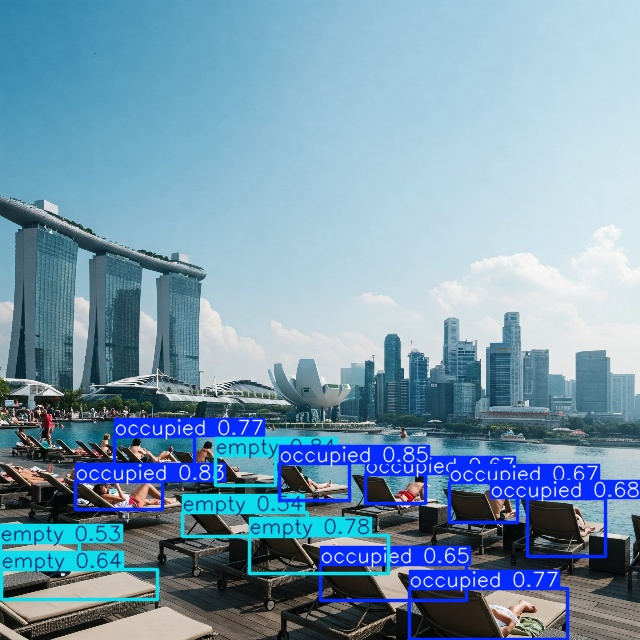

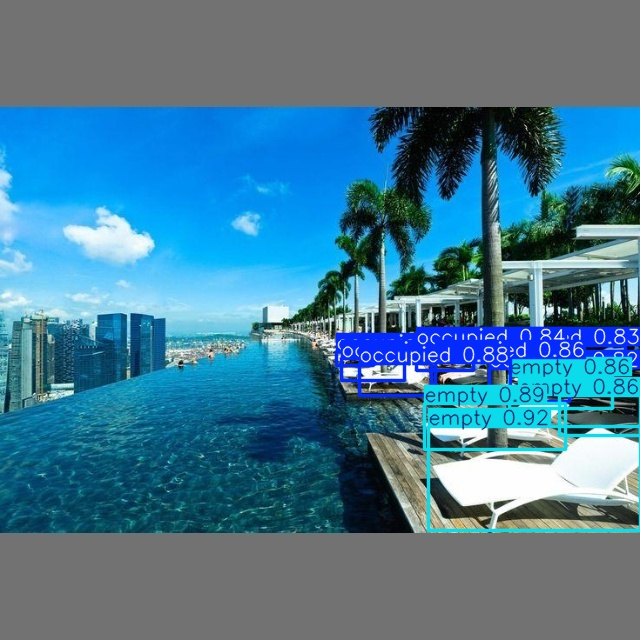

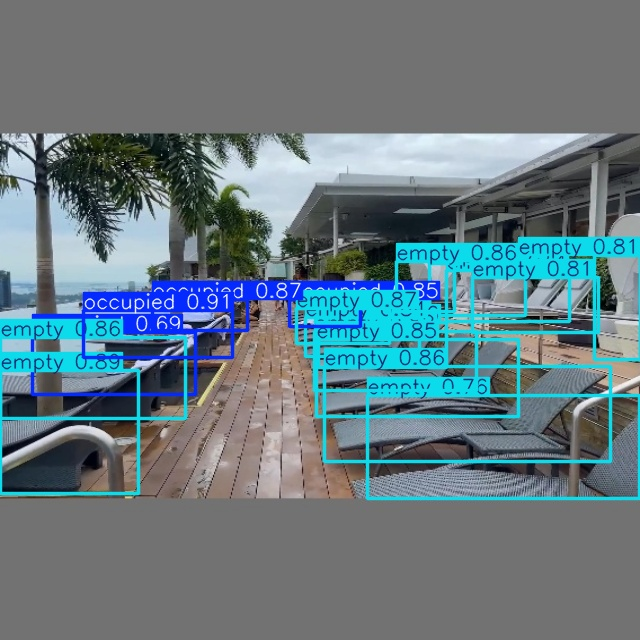

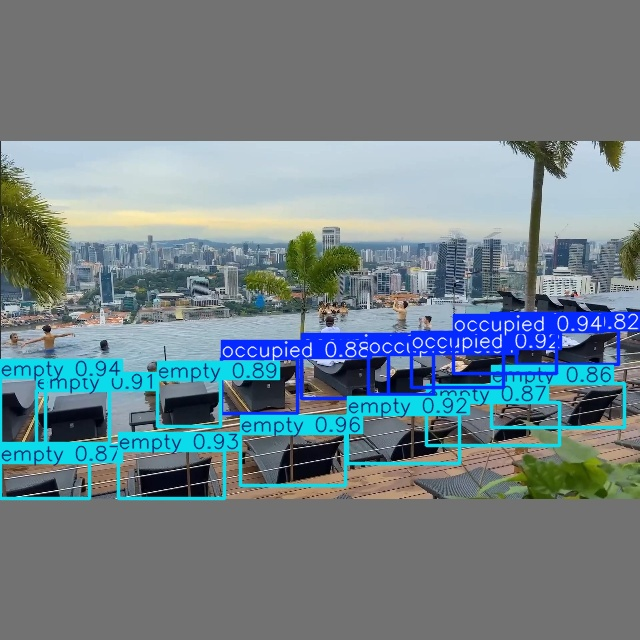

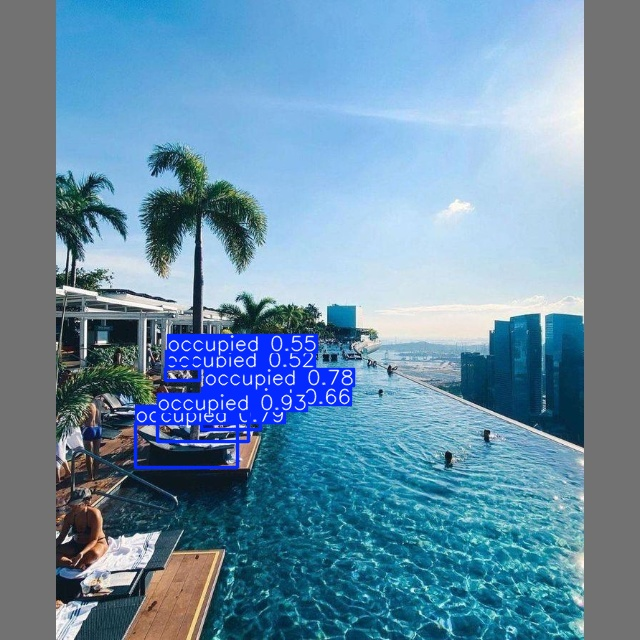

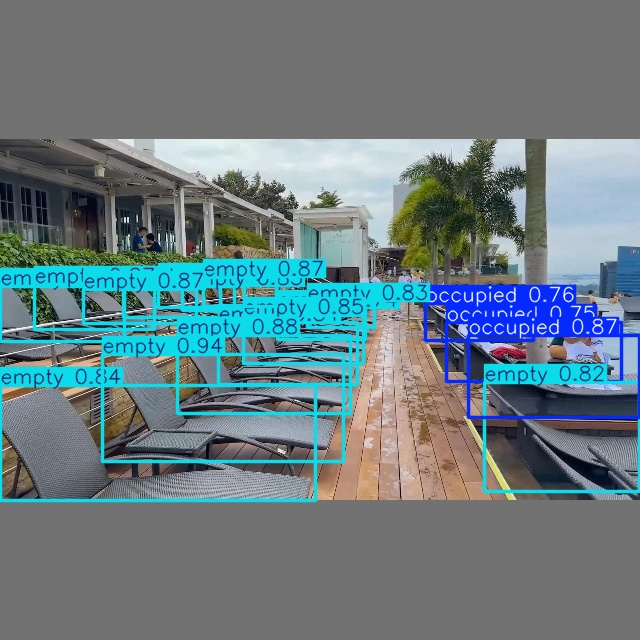

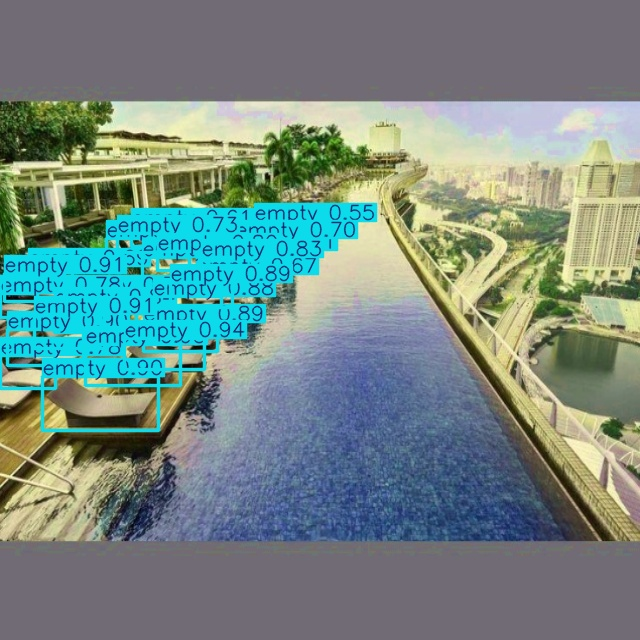

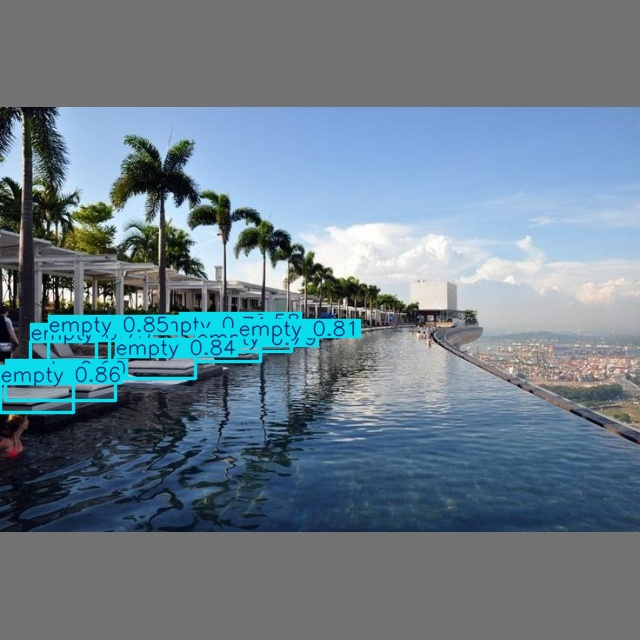

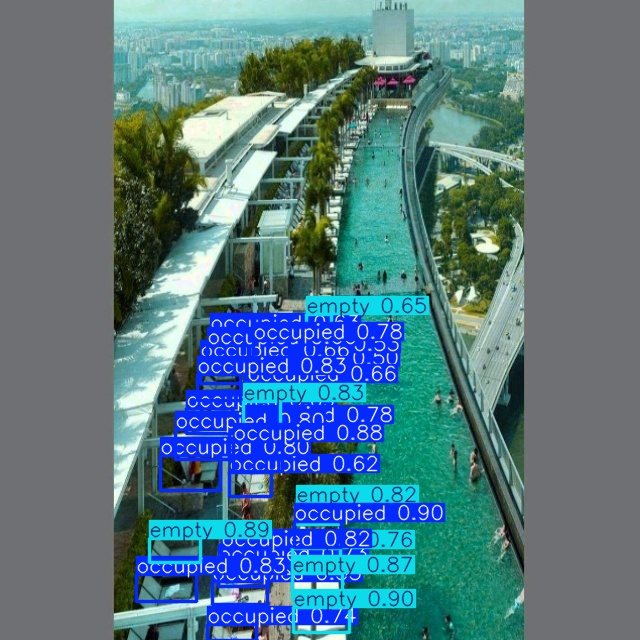

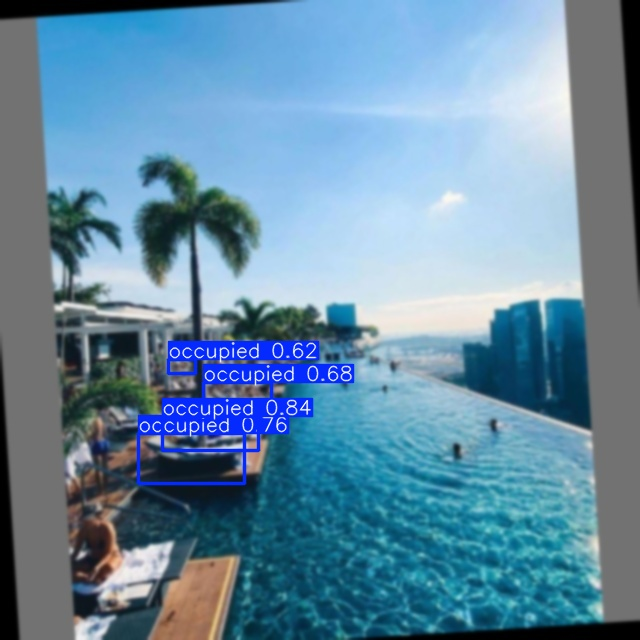

In [15]:
from ultralytics import YOLO
model_path = "/content/model/train/weights/best.pt"
# Load your trained YOLO model
# model = YOLO("/content/model/model.pt")  # Update the path if needed
model = YOLO(model_path)
test_image_path = "data/validation/images"

# Threshold CONFIGURATIONS
INFERENCE = config["INFERENCE"]
CONF_THRESHOLD = INFERENCE["CONF_THRESHOLD"]
IOU_THRESHOLD  = INFERENCE["IOU_THRESHOLD"]

# Run predict on images in a folder, use the variables from config if desired
results = model.predict(source=test_image_path, conf=0.5, iou=0.5, save=True)
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')


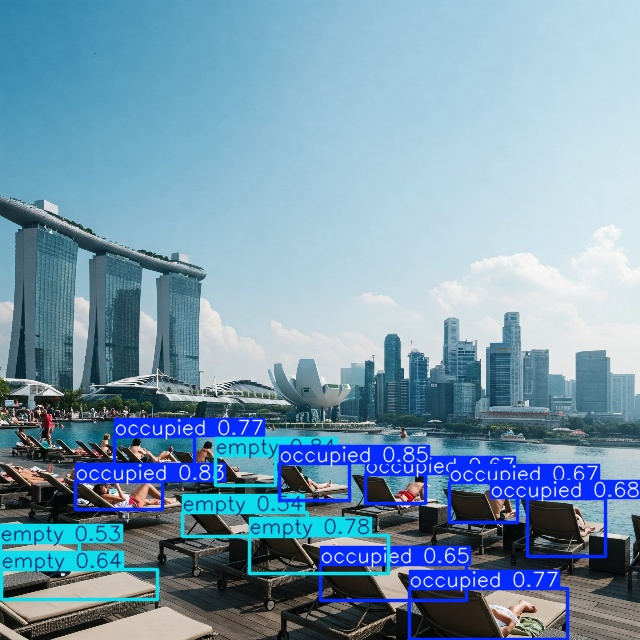

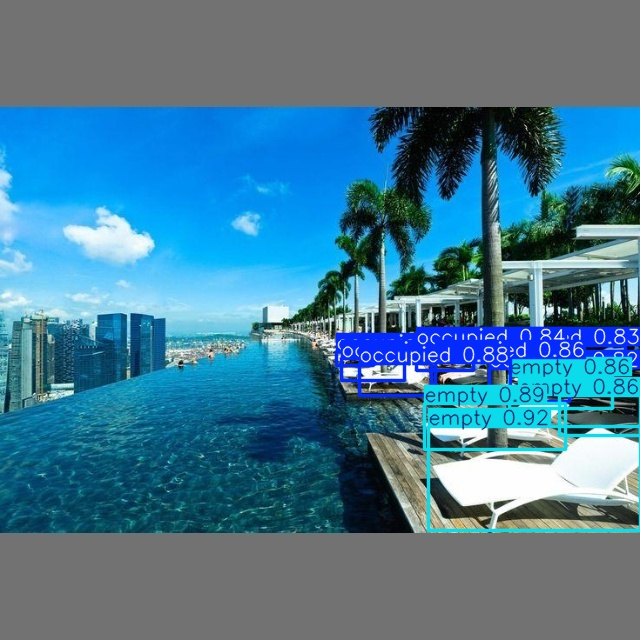

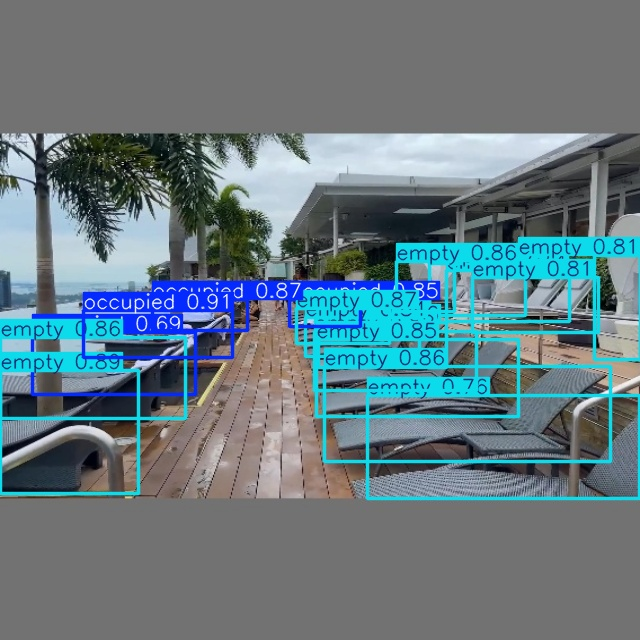

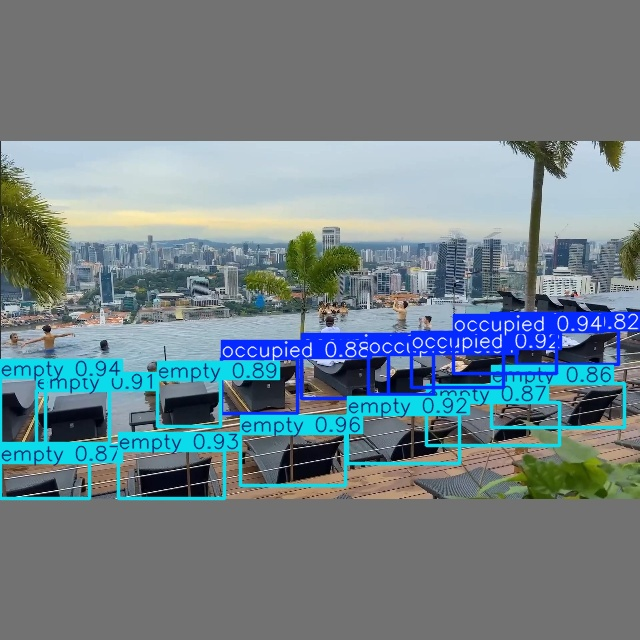

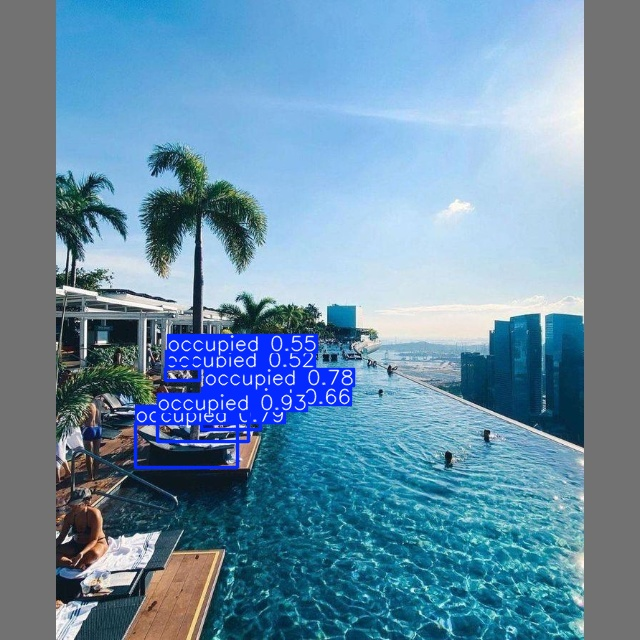

In [16]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:5]:
  display(Image(filename=image_path, height=400))
  print('\n')
